# Faostat world regions
We collect the data about crops yield (maiye, millet and others) that will be used as predictands of our model, and of some predictors (temperature anomalies, precipitations, fertilizers). The data is provided for each of the 5 contitnents. Africa, Asia, America, Europe, Oceania. The data from the 5 continents will be merged together to train a machine learning model. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score 
from time import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import dates
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.8.0


## Data analysis
We perform a data analysis before building the dataset that will be used to train the machine learning model

### Time series
The data for predictands and predictors are available as yearly time series so we define a time index that will be used for all of them. The time series used to train the model will start from the year 1961 and will end in the year 2021. We stop at the year 2021 since not for all the time series there are records for 2022 and 2023.    

In [2]:
year_index = pd.date_range('1961', '2022', freq='Y')
print('Start: {}\nEnd: {}'.format(year_index[0], year_index[len(year_index) - 1]))

Start: 1961-12-31 00:00:00
End: 2021-12-31 00:00:00


### Maize yield

In [3]:
path_maize_dataset = 'data/FAOSTAT_maize_world_regions.csv'
maize_yield_world_regions_tmp_df = pd.read_csv(path_maize_dataset, usecols=['Area', 'Year', 'Value'])
maize_yield_world_regions_tmp_df.shape

(310, 3)

In [4]:
maize_yield_world_regions_tmp_df.tail(2)

,Area,Year,Value
308,Oceania,2021,77616
309,Oceania,2022,86680


In [5]:
maize_yield_africa_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Africa'][:-1]
maize_yield_africa_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_africa_tmp_df.set_index(year_index, inplace=True)
maize_yield_africa_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_africa_tmp_df.rename(columns={'Value':'Maize Yield (100g/ha)'}, inplace=True)
maize_yield_africa_tmp_df.tail(2)

,Maize Yield (100g/ha)
2020-12-31,22366
2021-12-31,23331


In [6]:
maize_yield_americas_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Americas'][:-1]
maize_yield_americas_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_americas_tmp_df.set_index(year_index, inplace=True)
maize_yield_americas_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_americas_tmp_df.rename(columns={'Value':'Maize Yield (100g/ha)'}, inplace=True)
maize_yield_americas_tmp_df.tail(2)

,Maize Yield (100g/ha)
2020-12-31,79049
2021-12-31,77992


In [7]:
maize_yield_asia_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Asia'][:-1]
maize_yield_asia_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_asia_tmp_df.set_index(year_index, inplace=True)
maize_yield_asia_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_asia_tmp_df.rename(columns={'Value':'Maize Yield (100g/ha)'}, inplace=True)
maize_yield_asia_tmp_df.tail(2)

,Maize Yield (100g/ha)
2020-12-31,55492
2021-12-31,55663


In [8]:
maize_yield_europe_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Europe'][:-1]
maize_yield_europe_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_europe_tmp_df.set_index(year_index, inplace=True)
maize_yield_europe_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_europe_tmp_df.rename(columns={'Value':'Maize Yield (100g/ha)'}, inplace=True)
maize_yield_europe_tmp_df.tail(2)

,Maize Yield (100g/ha)
2020-12-31,63878
2021-12-31,72027


In [9]:
maize_yield_oceania_tmp_df = maize_yield_world_regions_tmp_df[maize_yield_world_regions_tmp_df['Area']=='Oceania'][:-1]
maize_yield_oceania_tmp_df.drop('Area', axis=1, inplace=True)
maize_yield_oceania_tmp_df.set_index(year_index, inplace=True)
maize_yield_oceania_tmp_df.drop('Year', axis=1, inplace=True)
maize_yield_oceania_tmp_df.rename(columns={'Value':'Maize Yield (100g/ha)'}, inplace=True)
maize_yield_oceania_tmp_df.tail(2)

,Maize Yield (100g/ha)
2020-12-31,82188
2021-12-31,77616


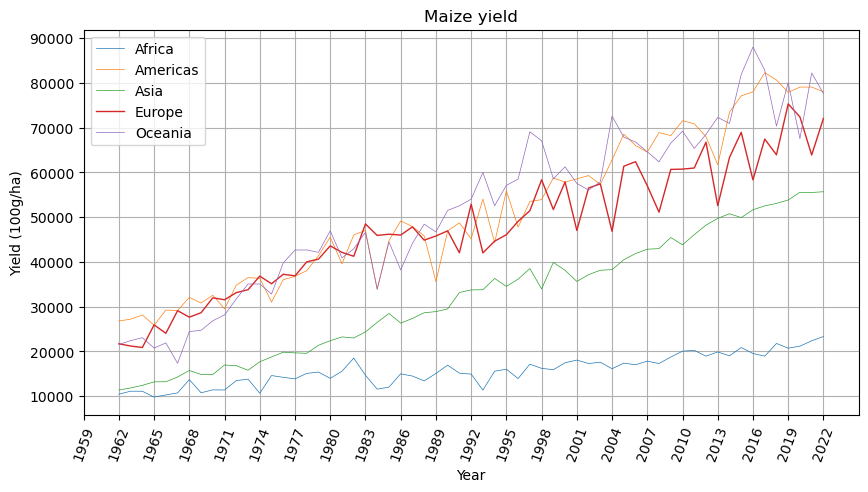

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Maize yield')
ax.set_xlabel('Year')
ax.set_ylabel('Yield (100g/ha)')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_maize_africa = ax.plot(maize_yield_africa_tmp_df, linewidth=0.5, label='Africa')
plt_maize_americas = ax.plot(maize_yield_americas_tmp_df, linewidth=0.5, label='Americas')
plt_maize_asia = ax.plot(maize_yield_asia_tmp_df, linewidth=0.5, label='Asia')
plt_maize_europe = ax.plot(maize_yield_europe_tmp_df, linewidth=1.0, label='Europe')
plt_maize_oceania = ax.plot(maize_yield_oceania_tmp_df, linewidth=0.5, label='Oceania')
plt.legend(loc='upper left')

We copy all the yield value in one dataframe 

In [11]:
maize_yield_world_regions_df = pd.DataFrame({'Maize Yield (100g/ha)': maize_yield_africa_tmp_df['Maize Yield (100g/ha)'].values})

i = maize_yield_africa_tmp_df.shape[0]
for row in maize_yield_americas_tmp_df['Maize Yield (100g/ha)'].values:
    maize_yield_world_regions_df.loc[i] = row
    i += 1

for row in maize_yield_asia_tmp_df['Maize Yield (100g/ha)'].values:
    maize_yield_world_regions_df.loc[i] = row
    i += 1

for row in maize_yield_europe_tmp_df['Maize Yield (100g/ha)'].values:
    maize_yield_world_regions_df.loc[i] = row
    i += 1

for row in maize_yield_oceania_tmp_df['Maize Yield (100g/ha)'].values:
    maize_yield_world_regions_df.loc[i] = row
    i += 1

maize_yield_world_regions_df.shape

(305, 1)

### Temperature change on land

In [12]:
path_temperature_dataset = 'data/FAOSTAT_Annual_temp_change_on_land_world_regions.csv'
temperature_tmp_df = pd.read_csv(path_temperature_dataset, usecols=['Area', 'Element', 'Year', 'Value'])
temperature_tmp_df.tail(2)

,Area,Element,Year,Value
628,Oceania,Standard Deviation,2022,0.305
629,Oceania,Standard Deviation,2023,0.305


In [13]:
temperature_world_tmp_df = temperature_tmp_df[temperature_tmp_df['Element']=='Temperature change']
temperature_world_tmp_df.drop('Element', axis=1, inplace=True)
temperature_world_tmp_df.shape

(315, 3)

In [14]:
temperature_africa_tmp_df = temperature_world_tmp_df[temperature_world_tmp_df['Area']=='Africa'][:-2]
temperature_africa_tmp_df.drop(['Area'], axis=1, inplace=True)
temperature_africa_tmp_df.set_index(year_index, inplace=True)
temperature_africa_tmp_df.drop('Year', axis=1, inplace=True)
temperature_africa_tmp_df.rename(columns={'Value':'Temp. change (°C)'}, inplace=True)
temperature_africa_tmp_df.tail(2)

,Temp. change (°C)
2020-12-31,1.200
2021-12-31,1.396


In [15]:
temperature_americas_tmp_df = temperature_world_tmp_df[temperature_world_tmp_df['Area']=='Americas'][:-2]
temperature_americas_tmp_df.drop(['Area'], axis=1, inplace=True)
temperature_americas_tmp_df.set_index(year_index, inplace=True)
temperature_americas_tmp_df.drop('Year', axis=1, inplace=True)
temperature_americas_tmp_df.rename(columns={'Value':'Temp. change (°C)'}, inplace=True)
temperature_americas_tmp_df.tail(2)

,Temp. change (°C)
2020-12-31,1.303
2021-12-31,1.558


In [16]:
temperature_asia_tmp_df = temperature_world_tmp_df[temperature_world_tmp_df['Area']=='Asia'][:-2]
temperature_asia_tmp_df.drop(['Area'], axis=1, inplace=True)
temperature_asia_tmp_df.set_index(year_index, inplace=True)
temperature_asia_tmp_df.drop('Year', axis=1, inplace=True)
temperature_asia_tmp_df.rename(columns={'Value':'Temp. change (°C)'}, inplace=True)
temperature_asia_tmp_df.tail(2)

,Temp. change (°C)
2020-12-31,1.506
2021-12-31,1.540


In [17]:
temperature_europe_tmp_df = temperature_world_tmp_df[temperature_world_tmp_df['Area']=='Europe'][:-2]
temperature_europe_tmp_df.drop(['Area'], axis=1, inplace=True)
temperature_europe_tmp_df.set_index(year_index, inplace=True)
temperature_europe_tmp_df.drop('Year', axis=1, inplace=True)
temperature_europe_tmp_df.rename(columns={'Value':'Temp. change (°C)'}, inplace=True)
temperature_europe_tmp_df.tail(2)

,Temp. change (°C)
2020-12-31,3.332
2021-12-31,1.583


In [18]:
temperature_oceania_tmp_df = temperature_world_tmp_df[temperature_world_tmp_df['Area']=='Oceania'][:-2]
temperature_oceania_tmp_df.drop(['Area'], axis=1, inplace=True)
temperature_oceania_tmp_df.set_index(year_index, inplace=True)
temperature_oceania_tmp_df.drop('Year', axis=1, inplace=True)
temperature_oceania_tmp_df.rename(columns={'Value':'Temp. change (°C)'}, inplace=True)
temperature_oceania_tmp_df.tail(2)

,Temp. change (°C)
2020-12-31,1.315
2021-12-31,0.629


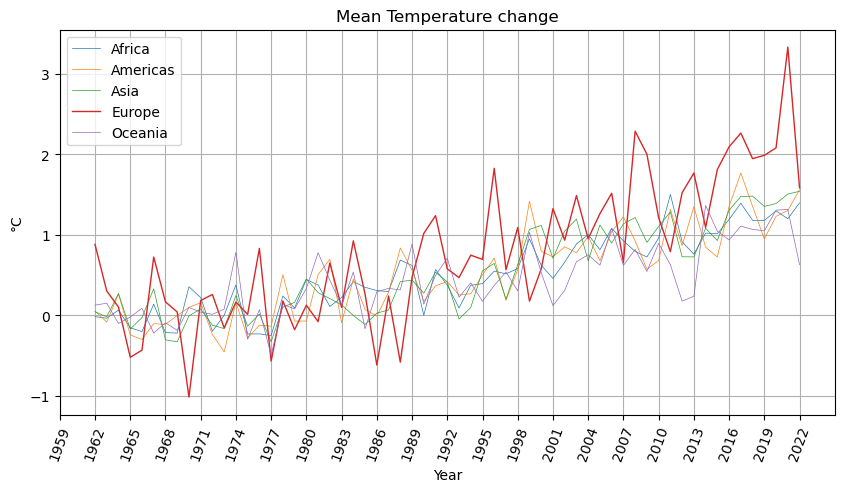

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Mean Temperature change')
ax.set_xlabel('Year')
ax.set_ylabel('°C')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_temperature_africa = ax.plot(temperature_africa_tmp_df, linewidth=0.5, label='Africa')
plt_temperature_americas = ax.plot(temperature_americas_tmp_df, linewidth=0.5, label='Americas')
plt_temperature_asia = ax.plot(temperature_asia_tmp_df, linewidth=0.5, label='Asia')
plt_temperature_europe = ax.plot(temperature_europe_tmp_df, linewidth=1.0, label='Europe')
plt_temperature_oceania = ax.plot(temperature_oceania_tmp_df, linewidth=0.5, label='Oceania')
plt.legend(loc='upper left')

We copy the temperature change data into one single dataframe

In [20]:
temperature_df = pd.DataFrame({'Temp. change (°C)': temperature_africa_tmp_df['Temp. change (°C)'].values})

i = temperature_africa_tmp_df.shape[0]
for row in temperature_americas_tmp_df['Temp. change (°C)'].values:
    temperature_df.loc[i] = row
    i += 1

for row in temperature_asia_tmp_df['Temp. change (°C)'].values:
    temperature_df.loc[i] = row
    i += 1

for row in temperature_europe_tmp_df['Temp. change (°C)'].values:
    temperature_df.loc[i] = row
    i += 1

for row in temperature_oceania_tmp_df['Temp. change (°C)'].values:
    temperature_df.loc[i] = row
    i += 1

temperature_df.shape

(305, 1)

### Fertilizers by nutrient (synthetic fertilizers)
Nitrogen, phosphate P205, and potash.

In [21]:
path_fertilizers_dataset = 'data/FAOSTAT_synthetic_fertilizers_world_regions.csv'
fertilizers_tmp_df = pd.read_csv(path_fertilizers_dataset, usecols=['Area', 'Item', 'Year', 'Value'])
fertilizers_tmp_df.shape

(915, 4)

In [22]:
fertilizers_tmp_df.tail(2)

,Area,Item,Year,Value
913,Oceania,Nutrient potash K2O (total),2020,435423.36
914,Oceania,Nutrient potash K2O (total),2021,481150.46


In [23]:
fertilizers_nitrogen_tmp_df = fertilizers_tmp_df[fertilizers_tmp_df['Item']=='Nutrient nitrogen N (total)']
fertilizers_nitrogen_tmp_df.drop('Item', axis=1, inplace=True)
fertilizers_nitrogen_tmp_df.shape

(305, 3)

In [24]:
fertilizers_nitrogen_africa_tmp_df = fertilizers_nitrogen_tmp_df[fertilizers_nitrogen_tmp_df['Area']=='Africa']
fertilizers_nitrogen_africa_tmp_df.drop('Area', axis=1, inplace=True)
fertilizers_nitrogen_africa_tmp_df.set_index(year_index, inplace=True)
fertilizers_nitrogen_africa_tmp_df.drop('Year', axis=1, inplace=True)
fertilizers_nitrogen_africa_tmp_df.rename(columns={'Value':'Nitrogen (tons)'}, inplace=True)
fertilizers_nitrogen_africa_tmp_df.tail(2)

,Nitrogen (tons)
2020-12-31,4882455.25
2021-12-31,4788408.83


In [25]:
fertilizers_nitrogen_americas_tmp_df = fertilizers_nitrogen_tmp_df[fertilizers_nitrogen_tmp_df['Area']=='Americas']
fertilizers_nitrogen_americas_tmp_df.drop('Area', axis=1, inplace=True)
fertilizers_nitrogen_americas_tmp_df.set_index(year_index, inplace=True)
fertilizers_nitrogen_americas_tmp_df.drop('Year', axis=1, inplace=True)
fertilizers_nitrogen_americas_tmp_df.rename(columns={'Value':'Nitrogen (tons)'}, inplace=True)
fertilizers_nitrogen_americas_tmp_df.tail(2)

,Nitrogen (tons)
2020-12-31,26311930.79
2021-12-31,26909342.15


In [26]:
fertilizers_nitrogen_asia_tmp_df = fertilizers_nitrogen_tmp_df[fertilizers_nitrogen_tmp_df['Area']=='Asia']
fertilizers_nitrogen_asia_tmp_df.drop('Area', axis=1, inplace=True)
fertilizers_nitrogen_asia_tmp_df.set_index(year_index, inplace=True)
fertilizers_nitrogen_asia_tmp_df.drop('Year', axis=1, inplace=True)
fertilizers_nitrogen_asia_tmp_df.rename(columns={'Value':'Nitrogen (tons)'}, inplace=True)
fertilizers_nitrogen_asia_tmp_df.tail(2)

,Nitrogen (tons)
2020-12-31,62055358.94
2021-12-31,60285454.52


In [27]:
fertilizers_nitrogen_europe_tmp_df = fertilizers_nitrogen_tmp_df[fertilizers_nitrogen_tmp_df['Area']=='Europe']
fertilizers_nitrogen_europe_tmp_df.drop('Area', axis=1, inplace=True)
fertilizers_nitrogen_europe_tmp_df.set_index(year_index, inplace=True)
fertilizers_nitrogen_europe_tmp_df.drop('Year', axis=1, inplace=True)
fertilizers_nitrogen_europe_tmp_df.rename(columns={'Value':'Nitrogen (tons)'}, inplace=True)
fertilizers_nitrogen_europe_tmp_df.tail(2)

,Nitrogen (tons)
2020-12-31,15451094.10
2021-12-31,14897692.08


In [28]:
fertilizers_nitrogen_oceania_tmp_df = fertilizers_nitrogen_tmp_df[fertilizers_nitrogen_tmp_df['Area']=='Oceania']
fertilizers_nitrogen_oceania_tmp_df.drop('Area', axis=1, inplace=True)
fertilizers_nitrogen_oceania_tmp_df.set_index(year_index, inplace=True)
fertilizers_nitrogen_oceania_tmp_df.drop('Year', axis=1, inplace=True)
fertilizers_nitrogen_oceania_tmp_df.rename(columns={'Value':'Nitrogen (tons)'}, inplace=True)
fertilizers_nitrogen_oceania_tmp_df.tail(2)

,Nitrogen (tons)
2020-12-31,1840819.88
2021-12-31,1807270.41


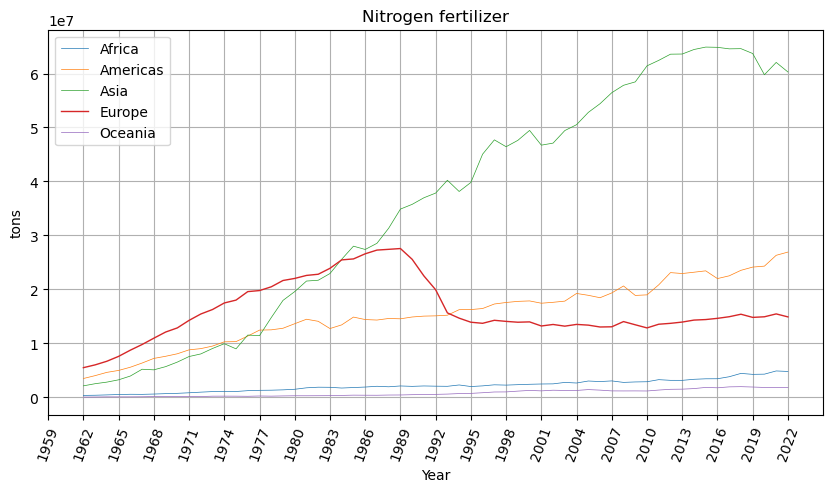

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Nitrogen fertilizer')
ax.set_xlabel('Year')
ax.set_ylabel('tons')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_nitrogen_africa = ax.plot(fertilizers_nitrogen_africa_tmp_df, linewidth=0.5, label='Africa')
plt_nitrogen_americas = ax.plot(fertilizers_nitrogen_americas_tmp_df, linewidth=0.5, label='Americas')
plt_nitrogen_asia = ax.plot(fertilizers_nitrogen_asia_tmp_df, linewidth=0.5, label='Asia')
plt_nitrogen_europe = ax.plot(fertilizers_nitrogen_europe_tmp_df, linewidth=1.0, label='Europe')
plt_nitrogen_oceania = ax.plot(fertilizers_nitrogen_oceania_tmp_df, linewidth=0.5, label='Oceania')
plt.legend(loc='upper left')

In [30]:
fertilizers_df = pd.DataFrame({'Nitrogen (tons)': fertilizers_nitrogen_africa_tmp_df['Nitrogen (tons)'].values})
i = temperature_africa_tmp_df.shape[0]

for row in fertilizers_nitrogen_americas_tmp_df['Nitrogen (tons)'].values:
    fertilizers_df.loc[i] = row
    i += 1

for row in fertilizers_nitrogen_asia_tmp_df['Nitrogen (tons)'].values:
    fertilizers_df.loc[i] = row
    i += 1

for row in fertilizers_nitrogen_europe_tmp_df['Nitrogen (tons)'].values:
    fertilizers_df.loc[i] = row
    i += 1

for row in fertilizers_nitrogen_oceania_tmp_df['Nitrogen (tons)'].values:
    fertilizers_df.loc[i] = row
    i += 1

fertilizers_df.shape

(305, 1)

### Livestock manure

In [31]:
path_manure_dataset = 'data/FAOSTAT_Livestock_manure_world_regions.csv'
manure_tmp_df = pd.read_csv(path_manure_dataset, usecols=['Area', 'Year', 'Value'])
manure_tmp_df.shape

(305, 3)

In [32]:
manure_tmp_df.tail(2)

,Area,Year,Value
303,Oceania,2020,2.317287e+08
304,Oceania,2021,2.412670e+08


In [33]:
manure_africa_tmp_df = manure_tmp_df[manure_tmp_df['Area']=='Africa']
manure_africa_tmp_df.drop('Area', axis=1, inplace=True)
manure_africa_tmp_df.set_index(year_index, inplace=True)
manure_africa_tmp_df.drop('Year', axis=1, inplace=True)
manure_africa_tmp_df.rename(columns={'Value':'Manure (tons)'}, inplace=True)
manure_africa_tmp_df.tail(2)

,Manure (tons)
2020-12-31,1.623517e+09
2021-12-31,1.625832e+09


In [34]:
manure_americas_tmp_df = manure_tmp_df[manure_tmp_df['Area']=='Americas']
manure_americas_tmp_df.drop('Area', axis=1, inplace=True)
manure_americas_tmp_df.set_index(year_index, inplace=True)
manure_americas_tmp_df.drop('Year', axis=1, inplace=True)
manure_americas_tmp_df.rename(columns={'Value':'Manure (tons)'}, inplace=True)
manure_americas_tmp_df.tail(2)

,Manure (tons)
2020-12-31,5.919925e+09
2021-12-31,5.926018e+09


In [35]:
manure_asia_tmp_df = manure_tmp_df[manure_tmp_df['Area']=='Asia']
manure_asia_tmp_df.drop('Area', axis=1, inplace=True)
manure_asia_tmp_df.set_index(year_index, inplace=True)
manure_asia_tmp_df.drop('Year', axis=1, inplace=True)
manure_asia_tmp_df.rename(columns={'Value':'Manure (tons)'}, inplace=True)
manure_asia_tmp_df.tail(2)

,Manure (tons)
2020-12-31,1.248123e+10
2021-12-31,1.272839e+10


In [36]:
manure_europe_tmp_df = manure_tmp_df[manure_tmp_df['Area']=='Europe']
manure_europe_tmp_df.drop('Area', axis=1, inplace=True)
manure_europe_tmp_df.set_index(year_index, inplace=True)
manure_europe_tmp_df.drop('Year', axis=1, inplace=True)
manure_europe_tmp_df.rename(columns={'Value':'Manure (tons)'}, inplace=True)
manure_europe_tmp_df.tail(2)

,Manure (tons)
2020-12-31,7.057610e+09
2021-12-31,6.935996e+09


In [37]:
manure_oceania_tmp_df = manure_tmp_df[manure_tmp_df['Area']=='Oceania']
manure_oceania_tmp_df.drop('Area', axis=1, inplace=True)
manure_oceania_tmp_df.set_index(year_index, inplace=True)
manure_oceania_tmp_df.drop('Year', axis=1, inplace=True)
manure_oceania_tmp_df.rename(columns={'Value':'Manure (tons)'}, inplace=True)
manure_oceania_tmp_df.tail(2)

,Manure (tons)
2020-12-31,2.317287e+08
2021-12-31,2.412670e+08


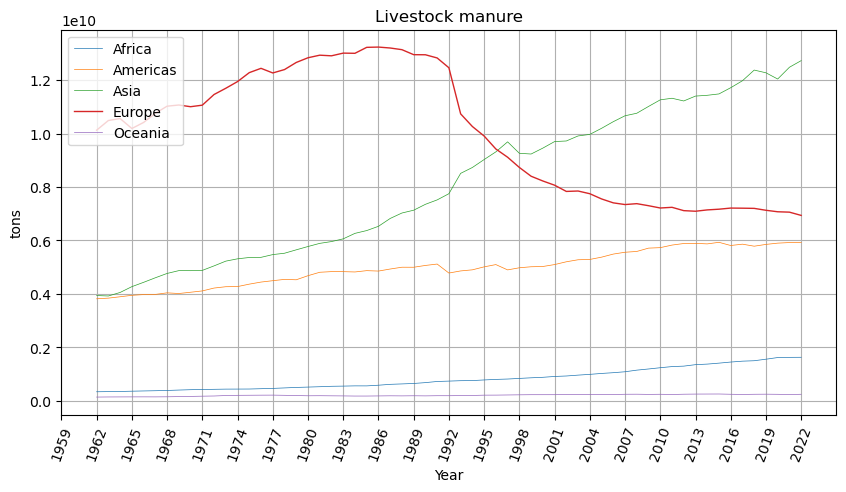

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Livestock manure')
ax.set_xlabel('Year')
ax.set_ylabel('tons')
ax.set_xticks(year_index)
ax.set_xticklabels(year_index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_manure_africa = ax.plot(manure_africa_tmp_df, linewidth=0.5, label='Africa')
plt_manure_americas = ax.plot(manure_americas_tmp_df, linewidth=0.5, label='Americas')
plt_manure_asia = ax.plot(manure_asia_tmp_df, linewidth=0.5, label='Asia')
plt_manure_europe = ax.plot(manure_europe_tmp_df, linewidth=1.0, label='Europe')
plt_manure_oceania = ax.plot(manure_oceania_tmp_df, linewidth=0.5, label='Oceania')
plt.legend(loc='upper left')

In [39]:
manure_df = pd.DataFrame({'Manure (tons)': manure_africa_tmp_df['Manure (tons)'].values})
i = manure_africa_tmp_df.shape[0]

for row in manure_americas_tmp_df['Manure (tons)'].values:
    manure_df.loc[i] = row
    i += 1

for row in manure_asia_tmp_df['Manure (tons)'].values:
    manure_df.loc[i] = row
    i += 1

for row in manure_europe_tmp_df['Manure (tons)'].values:
    manure_df.loc[i] = row
    i += 1

for row in manure_oceania_tmp_df['Manure (tons)'].values:
    manure_df.loc[i] = row
    i += 1

manure_df.shape

(305, 1)

### Precipitations
Data about precipitations at regional level can be retrieved from the [FAO Aquastat](https://www.fao.org/aquastat/en/) website.

### The world regions dataset
We build a dataset using the data for the predictand and the predictors. 

In [40]:
crop_world_regions_df = pd.concat([maize_yield_world_regions_df, temperature_df, fertilizers_df, manure_df], axis=1)
crop_world_regions_df

,Maize Yield (100g/ha),Temp. change (°C),Nitrogen (tons),Manure (tons)
0,10444,-0.017,352906.00,3.357745e+08
1,11112,-0.036,380243.00,3.407393e+08
2,11094,0.063,444446.00,3.466559e+08
3,9796,-0.156,510785.00,3.568206e+08
4,10272,-0.201,559718.00,3.659851e+08
...,...,...,...,...
300,70330,1.067,1969352.91,2.415524e+08
301,80041,1.049,1903106.46,2.448529e+08
302,67522,1.306,1823906.79,2.403588e+08
303,82188,1.315,1840819.88,2.317287e+08


In [41]:
crop_world_regions_df.to_csv('data/world_regions.csv')

We compute the correlation matrix between the features, then we plot the matrix as a heatmap

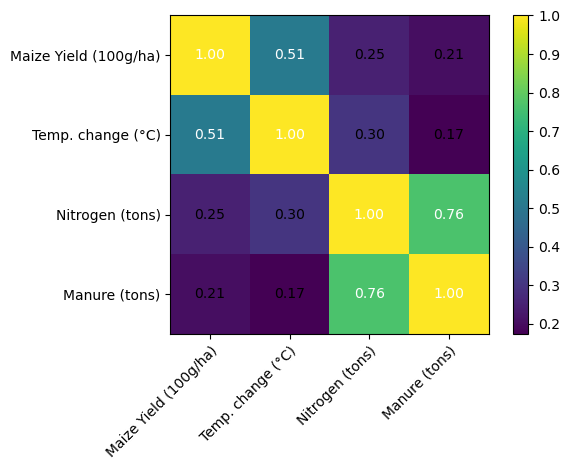

In [42]:
from mlxtend.plotting import heatmap
cm = np.corrcoef(crop_world_regions_df.values.T)
hm = heatmap(cm, row_names=crop_world_regions_df.columns, column_names=crop_world_regions_df.columns)
plt.tight_layout()
plt.show()

## Data preparation
Since the values of the features are different by orders of magnitude, the next step is to normalize them so that the range of values of each features will be within the interval [-1, 1]. The normalized dataset will be ready to train the model. In order to have the inferences from the model we will have to invert the result of the model. 

In [43]:
MAIZE = 0
TEMP_CHANGE = 1
NITROGEN = 2
MANURE = 3

In [44]:
X = crop_world_regions_df.iloc[:, [TEMP_CHANGE, NITROGEN, MANURE]].to_numpy()
y = crop_world_regions_df.iloc[:, [MAIZE]].to_numpy()

In [45]:
scaler_x = preprocessing.StandardScaler().fit(X)

We use the scaler to normalize the input variables

In [46]:
X_scaled = scaler_x.transform(X)
X_scaled.shape

(305, 3)

and the predictand's values

In [47]:
scaler_y = preprocessing.StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)
y_scaled.shape

(305, 1)

## Model training 
From the dataset we first create a train and a test set

In [48]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=0)
X_train_temp.shape, y_train_temp.shape, X_test.shape, y_test.shape

((274, 3), (274, 1), (31, 3), (31, 1))

Then we split the train dataset into a proper train dataset and a validation set

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((219, 3), (219, 1), (55, 3), (55, 1))

In [50]:
num_observations = X.shape[0]
num_observations

305

In [51]:
import random 
num_ensemble_members = 20 
from random import randint
random_states = [randint(2, num_observations) for p in range(1, num_ensemble_members + 1)]
len(random_states)

20

In [52]:
ensemble_members = np.zeros((num_observations,num_ensemble_members))
ensemble_members.shape

(305, 20)

In [53]:
for i in range(0, num_ensemble_members):
    random_state = random_states[i]
    tic = time()
    mlp_model = MLPRegressor(
               hidden_layer_sizes=(3, 1),
               activation='tanh',
               #learning_rate_init=0.01, not used with lbfgs solver
               early_stopping=True,
               random_state=random_state,
               solver='lbfgs',
               max_iter=20
            )
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=random_state)
    mlp_model.fit(X_train, y_train)
    model_sample = mlp_model.predict(X_scaled)
    ensemble_members[:, i] = model_sample
    print('Run {0:d}'.format(i))
    print(f"done in {time() - tic:.3f}s")
    print(f"Train R2 score: {mlp_model.score(X_train, y_train):.2f}")
    print(f"Validation R2 score: {mlp_model.score(X_val, y_val):.2f}\n")
    mlp_model=None

Run 0
done in 0.029s
Train R2 score: 0.41
Validation R2 score: 0.35

Run 1
done in 0.013s
Train R2 score: 0.38
Validation R2 score: 0.45

Run 2
done in 0.014s
Train R2 score: 0.33
Validation R2 score: 0.32

Run 3
done in 0.016s
Train R2 score: 0.31
Validation R2 score: 0.31

Run 4
done in 0.019s
Train R2 score: 0.40
Validation R2 score: 0.05

Run 5
done in 0.038s
Train R2 score: 0.37
Validation R2 score: 0.40

Run 6
done in 0.019s
Train R2 score: 0.42
Validation R2 score: 0.09

Run 7
done in 0.018s
Train R2 score: 0.24
Validation R2 score: 0.17

Run 8
done in 0.014s
Train R2 score: 0.41
Validation R2 score: 0.55

Run 9
done in 0.015s
Train R2 score: 0.38
Validation R2 score: 0.56

Run 10
done in 0.019s
Train R2 score: 0.40
Validation R2 score: 0.05

Run 11
done in 0.011s
Train R2 score: 0.32
Validation R2 score: 0.18

Run 12
done in 0.012s
Train R2 score: 0.32
Validation R2 score: 0.27

Run 13
done in 0.010s
Train R2 score: 0.40
Validation R2 score: 0.51

Run 14
done in 0.011s
Train R2

We have to transform back the result of the model from the normalized result 

In [54]:
predictions = scaler_y.inverse_transform(ensemble_members)

In [55]:
ensemble = predictions.sum(axis=1) / num_ensemble_members

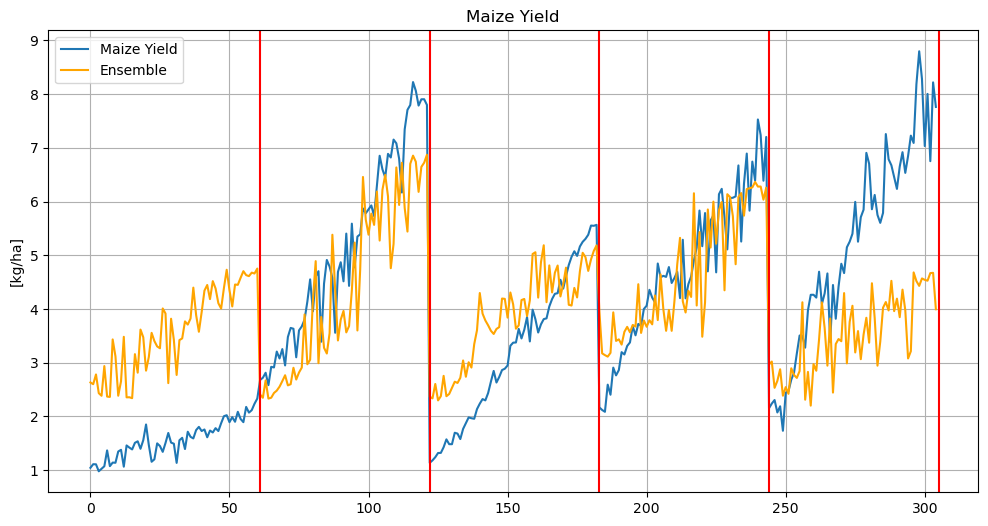

In [56]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield')
ax.set_ylabel('[kg/ha]');
ax.grid(True, which='both')
pd_maize_yield, = plt.plot(y / 10000, label='Maize Yield')
#pd_predictions_best, = plt.plot(best_model_predictions / 10000, label='Best model', color='green')
pd_ensemble, = plt.plot(ensemble / 10000, label='Ensemble', color='orange')
plt.legend(handles=[pd_maize_yield, pd_ensemble], loc='upper left')
plt.axvline(x = 61, color = 'red') # Africa
plt.axvline(x = 122, color = 'red') # Americas
plt.axvline(x = 183, color = 'red') # Asia
plt.axvline(x = 244, color = 'red') # Europe
plt.axvline(x = 305, color = 'red') # Oceania

## Americas & Europe
We perform the analysis with only two continents: America and Europe

In [57]:
maize_yield_am_eu_df = pd.DataFrame({'Maize Yield (100g/ha)': maize_yield_americas_tmp_df['Maize Yield (100g/ha)'].values})

i = maize_yield_americas_tmp_df.shape[0]
for row in maize_yield_europe_tmp_df['Maize Yield (100g/ha)'].values:
    maize_yield_am_eu_df.loc[i] = row
    i += 1
    
maize_yield_am_eu_df.shape

(122, 1)

In [58]:
temperature_am_eu_df = pd.DataFrame({'Temp. change (°C)': temperature_americas_tmp_df['Temp. change (°C)'].values})

i = temperature_americas_tmp_df.shape[0]
for row in temperature_europe_tmp_df['Temp. change (°C)'].values:
    temperature_am_eu_df.loc[i] = row
    i += 1

temperature_am_eu_df.shape

(122, 1)

In [59]:
fertilizers_am_eu_df = pd.DataFrame({'Nitrogen (tons)': fertilizers_nitrogen_americas_tmp_df['Nitrogen (tons)'].values})

i = temperature_americas_tmp_df.shape[0]
for row in fertilizers_nitrogen_europe_tmp_df['Nitrogen (tons)'].values:
    fertilizers_am_eu_df.loc[i] = row
    i += 1

fertilizers_am_eu_df.shape

(122, 1)

In [60]:
manure_am_eu_df = pd.DataFrame({'Manure (tons)': manure_americas_tmp_df['Manure (tons)'].values})
i = manure_americas_tmp_df.shape[0]

for row in manure_europe_tmp_df['Manure (tons)'].values:
    manure_am_eu_df.loc[i] = row
    i += 1

manure_am_eu_df.shape

(122, 1)

In [61]:
crop_am_eu_df = pd.concat([maize_yield_am_eu_df, temperature_am_eu_df, fertilizers_am_eu_df, manure_am_eu_df], axis=1)
crop_am_eu_df

,Maize Yield (100g/ha),Temp. change (°C),Nitrogen (tons),Manure (tons)
0,26789,0.053,3481600.27,3.815436e+09
1,27199,-0.084,4013385.11,3.839931e+09
2,28135,0.264,4619548.48,3.891040e+09
3,25828,-0.244,4978095.43,3.945130e+09
4,29233,-0.300,5574035.20,3.973439e+09
...,...,...,...,...
117,63916,1.946,15392135.56,7.199270e+09
118,75282,1.987,14807768.09,7.127969e+09
119,72371,2.080,14919249.40,7.072276e+09
120,63878,3.332,15451094.10,7.057610e+09


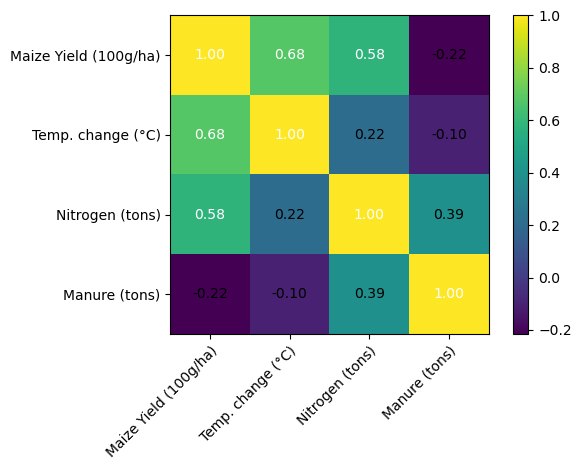

In [72]:
cm = np.corrcoef(crop_am_eu_df.values.T)
hm = heatmap(cm, row_names=crop_am_eu_df.columns, column_names=crop_am_eu_df.columns)
plt.tight_layout()
plt.show()

In [62]:
X = crop_am_eu_df.iloc[:, [TEMP_CHANGE, NITROGEN, MANURE]].to_numpy()
y = crop_am_eu_df.iloc[:, [MAIZE]].to_numpy()

In [64]:
scaler_x = preprocessing.StandardScaler().fit(X)
X_scaled = scaler_x.transform(X)
X_scaled.shape

(122, 3)

In [65]:
scaler_y = preprocessing.StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)
y_scaled.shape

(122, 1)

In [66]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=0)
X_train_temp.shape, y_train_temp.shape, X_test.shape, y_test.shape

((109, 3), (109, 1), (13, 3), (13, 1))

In [68]:
num_observations = X.shape[0]
num_observations

122

In [69]:
random_states = [randint(2, num_observations) for p in range(1, num_ensemble_members + 1)]
len(random_states)

20

In [70]:
ensemble_members = np.zeros((num_observations,num_ensemble_members))
ensemble_members.shape

(122, 20)

### MLP model for Americas and Europe
We use exactly the same code as before

In [71]:
for i in range(0, num_ensemble_members):
    random_state = random_states[i]
    tic = time()
    mlp_model = MLPRegressor(
               hidden_layer_sizes=(3, 1),
               activation='tanh',
               #learning_rate_init=0.01, not used with lbfgs solver
               early_stopping=True,
               random_state=random_state,
               solver='lbfgs',
               max_iter=20
            )
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=random_state)
    mlp_model.fit(X_train, y_train)
    model_sample = mlp_model.predict(X_scaled)
    ensemble_members[:, i] = model_sample
    print('Run {0:d}'.format(i))
    print(f"done in {time() - tic:.3f}s")
    print(f"Train R2 score: {mlp_model.score(X_train, y_train):.2f}")
    print(f"Validation R2 score: {mlp_model.score(X_val, y_val):.2f}\n")
    mlp_model=None

Run 0
done in 0.020s
Train R2 score: 0.88
Validation R2 score: 0.85

Run 1
done in 0.015s
Train R2 score: 0.88
Validation R2 score: 0.70

Run 2
done in 0.015s
Train R2 score: 0.91
Validation R2 score: -0.11

Run 3
done in 0.016s
Train R2 score: 0.85
Validation R2 score: 0.64

Run 4
done in 0.013s
Train R2 score: 0.82
Validation R2 score: 0.92

Run 5
done in 0.015s
Train R2 score: 0.84
Validation R2 score: 0.91

Run 6
done in 0.024s
Train R2 score: 0.89
Validation R2 score: 0.87

Run 7
done in 0.016s
Train R2 score: 0.84
Validation R2 score: 0.60

Run 8
done in 0.013s
Train R2 score: 0.83
Validation R2 score: 0.63

Run 9
done in 0.011s
Train R2 score: 0.82
Validation R2 score: 0.73

Run 10
done in 0.013s
Train R2 score: 0.80
Validation R2 score: 0.95

Run 11
done in 0.013s
Train R2 score: 0.79
Validation R2 score: 0.81

Run 12
done in 0.021s
Train R2 score: 0.81
Validation R2 score: 0.90

Run 13
done in 0.034s
Train R2 score: 0.92
Validation R2 score: 0.90

Run 14
done in 0.030s
Train R

In [73]:
predictions = scaler_y.inverse_transform(ensemble_members)
ensemble = predictions.sum(axis=1) / num_ensemble_members

### Linear regression model for America and Europe

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=0)

In [80]:
linear_regr = linear_model.LinearRegression()
linear_regr.fit(X_train, y_train)
linear_predictions = linear_regr.predict(X_scaled)
linear_predictions.shape

(122, 1)

In [81]:
linear_test_predictions = linear_regr.predict(X_test)
linear_rmse = mean_squared_error(linear_test_predictions, y_test)
print('Root mean squared error: {:.2f}'.format(linear_rmse))

Root mean squared error: 0.26


In [82]:
linear_coeffs = linear_regr.coef_
print('Linear regression coefficients: {}'.format(linear_coeffs))

Linear regression coefficients: [[ 0.49029171  0.62877449 -0.39841472]]


In [83]:
predictions = scaler_y.inverse_transform(linear_predictions)

### Models visualization

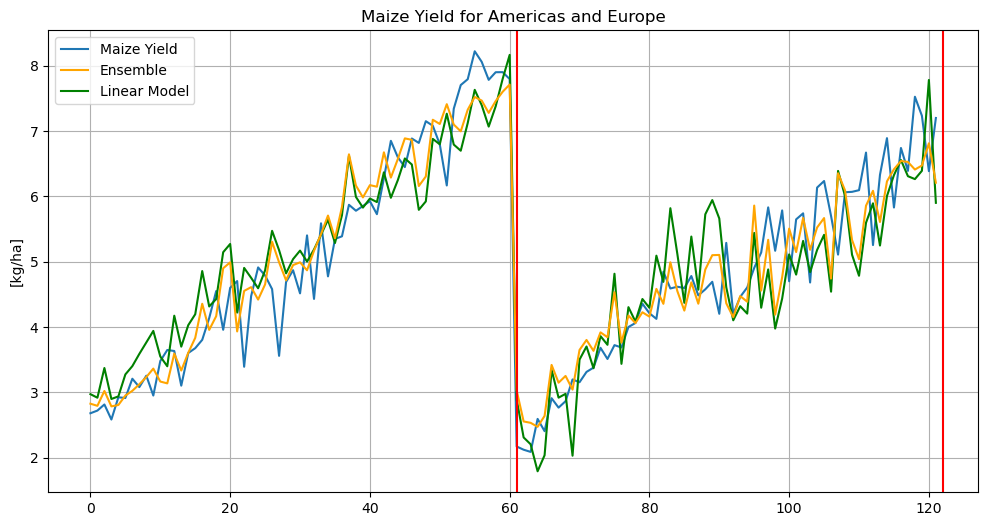

In [86]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yield for Americas and Europe')
ax.set_ylabel('[kg/ha]');
ax.grid(True, which='both')
pd_maize_yield, = plt.plot(y / 10000, label='Maize Yield')
pd_linear, = plt.plot(predictions / 10000, label='Linear Model', color='green')
pd_ensemble, = plt.plot(ensemble / 10000, label='Ensemble', color='orange')
plt.legend(handles=[pd_maize_yield, pd_ensemble, pd_linear], loc='upper left')
plt.axvline(x = 61, color = 'red') # Americas
plt.axvline(x = 122, color = 'red') # Europe